In [ ]:
%%bash
# Some set-up specific to google colab.
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
git clone https://github.com/SIDN-IAP/compas-python.git compas-python 2>> install.log
cp compas-python/compas-scores-two-years.csv .

# COMPAS analysis

We recreate the first section of the [Propublica COMPAS analysis](https://github.com/propublica/compas-analysis) in Python.

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.



## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.



In [ ]:
import pandas as pd
import datetime

In [ ]:
raw_data = pd.read_csv('./compas-scores-two-years.csv')
print('Num rows: %d' %len(raw_data))

df = raw_data

Num rows: 7214


However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

 - If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
 - We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
 - In a similar vein, ordinary traffic offenses -- those with a df of 'O' -- will not result in Jail time are removed (only two of them).
 - We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
 - We remove rows where there is no score_text ('N/A')

In [ ]:
df = df[((df['days_b_screening_arrest'] <=30) &
      (df['days_b_screening_arrest'] >= -30) &
      (df['is_recid'] != -1) &
      (df['c_charge_degree'] != 'O') &
      (df['score_text'] != 'N/A')
     )]

print('Num rows filtered: %d' % len(df))

Num rows filtered: 6172


Higher COMPAS scores are slightly correlated with a longer length of stay.



In [ ]:
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr

In [ ]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [ ]:
df['length_of_stay'] = (df['c_jail_out'].apply(date_from_str) - df['c_jail_in'].apply(date_from_str)).dt.total_seconds()
stay_score_corr = pearsonr(df['length_of_stay'], df['decile_score'])[0]
print('Correlation btw stay length and COMPAS scores: %.3f' % stay_score_corr)

Correlation btw stay length and COMPAS scores: 0.207


/afs/csail.mit.edu/u/d/davidbau/.conda/envs/p3t13/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


After filtering we have the following demographic breakdown:

In [ ]:
df['age_cat'].value_counts()

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [ ]:
df['race'].value_counts()

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [ ]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [ ]:
df['score_text'].value_counts()

Low       3421
Medium    1607
High      1144
Name: score_text, dtype: int64

In [ ]:
pd.crosstab(df.sex, df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [ ]:
df['sex'].value_counts()

Male      4997
Female    1175
Name: sex, dtype: int64

In [ ]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))

Men: 80.96%
Women: 19.04%


In [ ]:
print('Num with two-year recidivism: %d' % len(df['two_year_recid'] == 1))

Num with two-year recidivism: 6172


In [ ]:
print('Num with two-year recidivism: %.2f%%' % (len(df[df['two_year_recid'] == 1]) / len(df) * 100.))

Num with two-year recidivism: 45.51%


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



In [ ]:
%matplotlib inline

from matplotlib import pyplot as plt

Text(0, 0.5, 'Count')

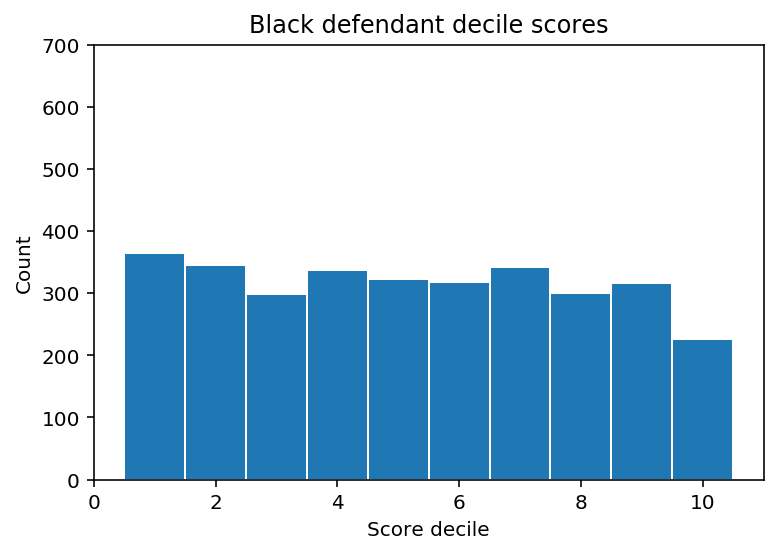

In [ ]:
black_df = df[df['race'] == 'African-American']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('Black defendant decile scores')
plt.xlabel('Score decile')
plt.ylabel('Count')

Text(0.5, 0, 'Score decile')

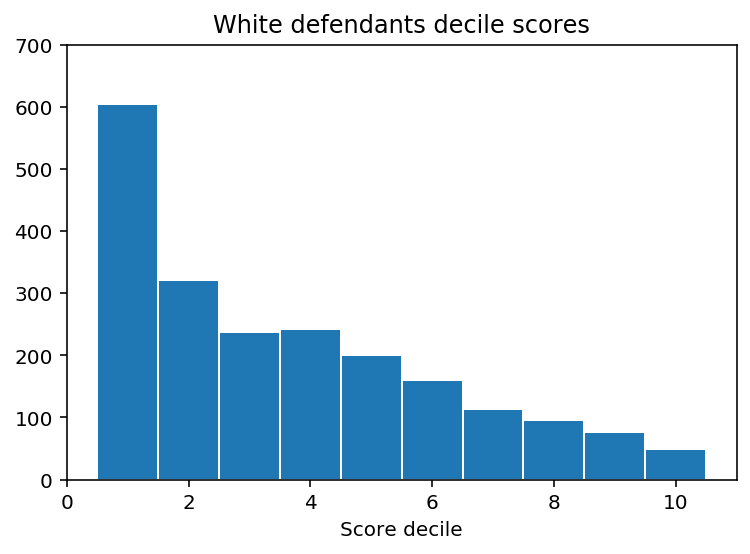

In [ ]:
black_df = df[df['race'] == 'Caucasian']
black_df['decile_score'].hist(edgecolor='white', bins=np.arange(13)-0.5,grid=False)
plt.ylim([0,700])
plt.xlim([0,11])
plt.title('White defendants decile scores')
plt.xlabel('Score decile')

In [ ]:
pd.crosstab(df.decile_score, df.race)

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(solver='lbfgs')

In [ ]:
df_crime = pd.get_dummies(df['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df['age_cat'],prefix='age')
df_race = pd.get_dummies(df['race'],prefix='race')
df_gender = pd.get_dummies(df['sex'],prefix='sex',drop_first=True)
df_score = pd.get_dummies(df['score_text'] != 'Low',prefix='score_factor',drop_first=True)

In [ ]:
df_lr = pd.concat([df_crime, df_age,df_race,df_gender,
                   df['priors_count'],df['two_year_recid']
                  ],axis=1)

In [ ]:
lr.fit(df_lr,df_score.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
cols = np.concatenate([df_crime.columns.values,
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

In [ ]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)')
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.335 (Intercept)
-0.310 crimefactor_M
0.018 age_25 - 45
-1.328 age_Greater than 45
1.319 age_Less than 25
0.490 race_African-American
-0.201 race_Asian
0.013 race_Caucasian
-0.409 race_Hispanic
0.909 race_Native American
-0.793 race_Other
-0.219 sex_Male
0.268 priors_count
0.683 two_year_recid


Black defendants are 44% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.



In [ ]:
control = np.exp(-1.335) / (1 + np.exp(-1.335))
black_odds = np.exp(0.490) / (1 - control + (control * np.exp(0.490)))
print('Black defendants: %.4f' % black_odds)

Black defendants: 1.4423
